In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from caffe2.proto import caffe2_pb2
from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)    
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace, models
import urllib
import operator
print("Required modules imported.")
import gc
import lmdb

Required modules imported.


In [2]:
CAFFE_MODELS = "/home/bingnan/Desktop/pytorch/build/caffe2/python/models"
IMAGE_LOCATION = 'image/flower.jpg'

MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

# codes are object codes
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print("Config set!")

Config set!


In [3]:
os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])

'/home/bingnan/Desktop/pytorch/build/caffe2/python/models/squeezenet/ilsvrc_2012_mean.npy'

In [4]:
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print ("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])

# Check to see if the files exist
if not os.path.exists(INIT_NET):
    print("WARNING: " + INIT_NET + " not found!")
else:
    if not os.path.exists(PREDICT_NET):
        print("WARNING: " + PREDICT_NET + " not found!")
    else:
        print("All needed files found!")

No mean file found!
mean was set to:  128
All needed files found!


## Image Preprocessing

Original Image Shape:  (300, 400, 3)
Image Shape after rescaling:  (227, 302, 3)
Image Shape after cropping:  (227, 227, 3)
CHW Image Shape: (3, 227, 227)
NCHW image (ready to be used as input):  (1, 3, 227, 227)


/home/bingnan/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bingnan/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


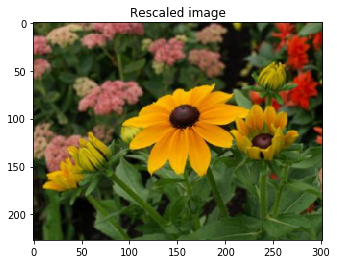

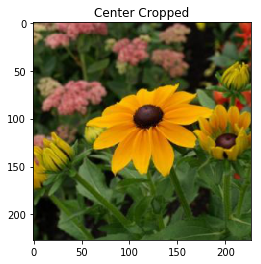

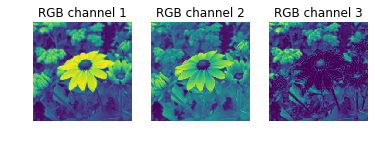

In [5]:
def crop_center(img, cropx, cropy):
    y, x, c = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

def rescale(img, input_height, input_width):
    aspect = img.shape[1] / float(img.shape[0])
    if aspect > 1:
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if aspect < 1:
        res = int(input_width / aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if aspect == 1:
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    return imgScaled

img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
print("Original Image Shape: " , img.shape)

img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after rescaling: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Rescaled image')

# the input should be 227 * 227
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after cropping: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Center Cropped')

# switch from HWC -> CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)

print('CHW Image Shape:', img.shape)

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))
    

# switch to BGR (RGB --> BGR)
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size axis which completes the formation of the NCHW shaped input that we want
img = img[np.newaxis, :, :, :].astype(np.float32)

print("NCHW image (ready to be used as input): ", img.shape)

## Prepare CNN and run the net

In [6]:
with open(INIT_NET, "rb") as f:
    init_net = f.read()
with open(PREDICT_NET, "rb") as f:
    predict_net = f.read()

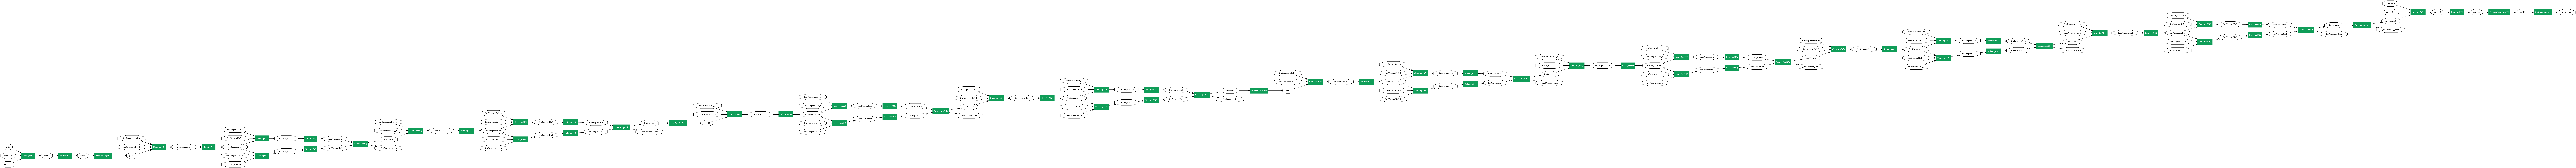

In [7]:
from IPython import display
from caffe2.python import net_drawer
net1 = caffe2_pb2.NetDef() 
net1.ParseFromString(predict_net)
graph = net_drawer.GetPydotGraph(net1.op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=1800)

In [8]:
# Initialize the predictor from the input protobufs
p = workspace.Predictor(init_net, predict_net)

# Run the net and return prediction
results = p.run({'data': img})

# Turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)
print("results shape: ", results.shape)

# Quick way to get the top-1 prediction result
# Squeeze out the unnecessary axis. This returns a 1-D array of length 1000
preds = np.squeeze(results)
# Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
curr_pred, curr_conf = max(enumerate(preds), key=operator.itemgetter(1))
print("Prediction: ", curr_pred)
print("Confidence: ", curr_conf)

results shape:  (1, 1, 1000, 1, 1)
Prediction:  985
Confidence:  0.88184613


## Process Results

In [9]:
from urllib.request import urlopen

results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:,0] = int(10)
arr[:,1:] = float(10)
for i, r in enumerate(results):
    i = i+1
    arr = np.append(arr, np.array([[i, r]]), axis=0)
    if (r > highest):
        highest = r
        index = i

N = 5
topN = sorted(arr, key=lambda x: x[1], reverse=True)[:N]
print('Raw top {} results: {}'.format(N, topN))
topN_inds = [int(x[0]) for x in topN]
print("Top {} classes in order: {}".format(N,topN_inds))

response = urlopen(codes)
class_LUT = []
for byte_line in response:
    line = byte_line.decode('utf-8')
    code, result = line.partition(':')[::2]
    code = code.strip()
    result = result.replace("'", '')
    if code.isdigit():
        class_LUT.append(result.split(',')[0][1:])

for n in topN:
    print("Model predicts '{}' with {}% confidence".format(class_LUT[int(n[0])],float("{0:.2f}".format(n[1]*100))))

Raw top 5 results: [array([985.0, 0.8818461298942566], dtype=object), array([309.0, 0.04823404550552368], dtype=object), array([995.0, 0.026204247027635574], dtype=object), array([988.0, 0.007224795408546925], dtype=object), array([325.0, 0.004194066859781742], dtype=object)]
Top 5 classes in order: [985, 309, 995, 988, 325]
Model predicts 'daisy' with 88.18% confidence
Model predicts 'bee' with 4.82% confidence
Model predicts 'earthstar' with 2.62% confidence
Model predicts 'acorn' with 0.72% confidence
Model predicts 'sulphur butterfly' with 0.42% confidence


## Feed more batches

In [10]:
import os
images = os.listdir('image')

In [11]:
NCHW_batch = np.zeros((len(images), 3, 227, 227))
print ("Batch Shape: ",NCHW_batch.shape)

for i, curr_img in enumerate(images):
    img = skimage.img_as_float(skimage.io.imread('image/'+curr_img)).astype(np.float32)
    img = rescale(img, 227, 227)
    img = crop_center(img, 227, 227)
    img = img.swapaxes(1, 2).swapaxes(0,1)
    img = img[(2, 1, 0), :, :] # RGB->BGR
    img = img * 225 - mean
    NCHW_batch[i] = img
    
print("NCHW image (ready to be used as input): ", NCHW_batch.shape)
results = p.run([NCHW_batch.astype(np.float32)])

results == np.asarray(results)

preds = np.squeeze(results)
print("Squeezed Predictions Shape, with batch size {}: {}".format(len(images),preds.shape))

# Describe the results
for i,pred in enumerate(preds):
    print("Results for: '{}'".format(images[i]))
    # Get the prediction and the confidence by finding the maximum value 
    #   and index of maximum value in preds array
    curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
    print("\tPrediction: ", curr_pred)
    print("\tClass Name: ", class_LUT[int(curr_pred)])
    print("\tConfidence: ", curr_conf)

Batch Shape:  (4, 3, 227, 227)
NCHW image (ready to be used as input):  (4, 3, 227, 227)
Squeezed Predictions Shape, with batch size 4: (4, 1000)
Results for: 'orangutan.jpg'
	Prediction:  365
	Class Name:  orangutan
	Confidence:  0.99706984
Results for: 'pretzel.jpg'
	Prediction:  932
	Class Name:  pretzel
	Confidence:  0.9988439
Results for: 'flower.jpg'
	Prediction:  985
	Class Name:  daisy
	Confidence:  0.81811345
Results for: 'airplane.jpg'
	Prediction:  404
	Class Name:  airliner
	Confidence:  0.44829407


/home/bingnan/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bingnan/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Transfer learning

### Create lmdb of the data I will use to do transfer learning

Please ignore all of these when run the training part

In [12]:
# # data
# train_path = '/home/bingnan/Desktop/train'

# classes = os.listdir(train_path)
# classes_dict = {v:k for k, v in enumerate(classes)}

In [13]:
# # count the number of file in train set
# total_cnt = 0
# for cls in classes:
#     total_cnt += len(os.listdir(train_path + '/'+cls))
# # create train data
# train_data = np.zeros((total_cnt, 3, 227, 227))
# train_label = np.zeros(total_cnt)

# counter = 0
# for cls in classes:
#     for file0 in os.listdir(train_path + '/' + cls):
#         # file is the name of file
#         curr_img = skimage.img_as_float(skimage.io.imread(train_path + '/' + cls + '/' + file0)).astype(np.float32)
#         curr_img = rescale(curr_img, 227, 227)
#         curr_img = crop_center(curr_img, 227, 227)
#         curr_img = curr_img.swapaxes(1, 2).swapaxes(0,1)
#         curr_img = curr_img[(2, 1, 0), :, :]
#         curr_img = curr_img * 225 - mean
#         train_data[counter, ] = curr_img
#         train_label[counter] = classes_dict[cls]
#         counter += 1
#     print('Finish class {}'.format(cls))

# del curr_img, classes
# gc.collect()

In [14]:
# # shuffle data and then split them into train test
# full_data = list(zip(train_data, train_label))

# from numpy.random import shuffle
# shuffle(full_data)

# train_proportion = 0.75
# train_num = int(np.round(total_cnt * train_proportion, 0))
# print('Training data {}, testing data {}'.format(train_num, total_cnt-train_num))

# train_x, train_y = zip(*full_data[:train_num])
# test_x, test_y = zip(*full_data[train_num:])

# train_x = np.array(train_x)
# train_y = np.array(train_y).astype(int)
# test_x = np.array(test_x)
# test_y = np.array(test_y).astype(int)

# del train_data, train_label
# gc.collect()

In [15]:
# # I test to put the first 5 imgs into our model
# results = p.run([train_x[:5].astype(np.float32)])

# results == np.asarray(results)

# preds = np.squeeze(results)
# # Describe the results
# for i,pred in enumerate(preds):
#     # Get the prediction and the confidence by finding the maximum value 
#     #   and index of maximum value in preds array
#     curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
#     print("\tPrediction: ", curr_pred)
#     print("\tClass Name: ", class_LUT[int(curr_pred)])
#     print("\tConfidence: ", curr_conf)

In [16]:
# # create lmdb
# def create_db(input_data, output_file):
#     print('>>> Writing database ...')
#     LMDB_MAP_SIZE = 50 * 1024 ** 3 # max size of this db
#     NUM_ROWS = input_data[0].shape[0]
#     env = lmdb.open(output_file, map_size = LMDB_MAP_SIZE)
    
#     with env.begin(write=True) as txn:
#         for j in range(0, NUM_ROWS):
#             label = input_data[1][j]
#             img_data = input_data[0][j]
            
#             tensor_protos = caffe2_pb2.TensorProtos()
#             img_tensor = tensor_protos.protos.add()
#             img_tensor.dims.extend(img_data.shape)
#             img_tensor.data_type = 1
            
#             flatten_img = img_data.reshape(np.prod(img_data.shape))
#             img_tensor.float_data.extend(flatten_img)
            
#             label_tensor = tensor_protos.protos.add()
#             label_tensor.data_type = 2
#             label_tensor.int32_data.append(label)
#             txn.put(
#                 '{}'.format(j).encode('ascii'),
#                  tensor_protos.SerializeToString()
#             )
#             if j % (NUM_ROWS // 5) == 0:
#                 print('{}% data finished'.format(np.round(j/NUM_ROWS * 100, 2)))
                
# # create dbs 
# train_data = [train_x, train_y]
# test_data = [test_x, test_y]
# create_db(train_data, '/home/bingnan/Desktop/data/train_lmdb')
# create_db(test_data, '/home/bingnan/Desktop/data/test_lmdb')

### Train part

In [17]:
# This chunk is used to look at the input, output shape of each layer. I feed an img and then get the blob shape

# readin img
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = img.swapaxes(1, 2).swapaxes(0, 1)
img = img[(2, 1, 0), :, :]
img = img * 255 - mean
img = img[np.newaxis, :, :, :].astype(np.float32)

# prepare net
pred_netdef = caffe2_pb2.NetDef()
pred_netdef.ParseFromString(predict_net)
init_netdef = caffe2_pb2.NetDef()
init_netdef.ParseFromString(init_net)

test_model = model_helper.ModelHelper('test_model', init_params=False)
test_model.net.AppendNet(core.Net(pred_netdef))
test_model.param_init_net.AppendNet(core.Net(init_netdef))

# run net
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite = True)
workspace.FeedBlob('data', img)
workspace.RunNet(test_model.net)

True

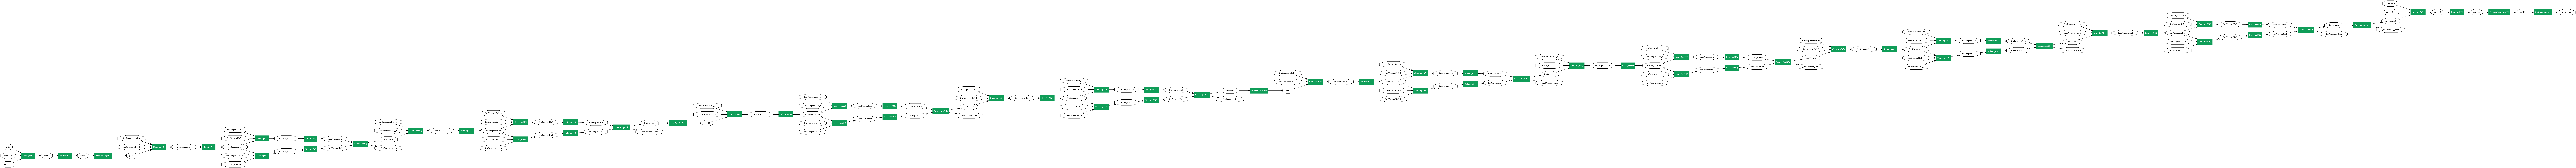

In [18]:
# This chunk is used to look at the input, output shape of each layer. I feed an img and then get the blob shape
graph2 = net_drawer.GetPydotGraph(test_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph2.create_png(), width=1800)

In [19]:
# This chunk is used to look at the input, output shape of each layer. I feed an img and then get the blob shape
workspace.FetchBlobs(['fire9/concat'])[0].shape

(1, 512, 14, 14)

From the above results, we can see that: (1) There are no true classes in the pre-trained model. (2) The confidence even for the most probable one is low. So we need to replace the last softmax layer and then train this layer.

In [20]:
# After looking at the model graph previously, we decide to replace the layer pool10
def splitmodel(predict_net, init_net, target, second_net_name='second net', second_init_net_name = 'second init net'):
    # get a dict: {output:input sets}
    lookup = dict()
    for op in predict_net.Proto().op:
        output = op.output[0]
        if output not in lookup:
            lookup[output] = set(op.input)
        else:
            lookup[output].update(op.input)
    # get the target
    visited = set() # what outputs we need to keep. This is used to target ops. But notice they could be external inputs
    unvisited = [target]
    external_inputs = set() # these are external inputs
    while len(unvisited) > 0:
        curr_output = unvisited.pop()
        visited.add(curr_output) # visited = external inputs + internal inputs
        try:
            curr_inputs = lookup[curr_output]
            for input in curr_inputs:
                if input not in visited:
                    unvisited.append(input)
        except KeyError as e: # internal inputs
            external_inputs.add(curr_output)
    
    # Construct net
    ## net
    second = caffe2_pb2.NetDef()
    second.name = second_net_name
    for op in predict_net.Proto().op:
        if op.output[0] in visited:
            new_op = second.op.add()
            new_op.CopyFrom(op)
    
    ## init net
    secondinit = caffe2_pb2.NetDef()
    secondinit.name = second_init_net_name
    for op in init_net.Proto().op:
        if op.output[0] in visited:
            new_op = secondinit.op.add()
            new_op.CopyFrom(op)
    # External output
    ## net
    for ins in predict_net.Proto().external_output:
        if ins in visited:
            g = second.external_output
            g.append(ins)
#     ## init net
#     for ins in init_net.Proto().external_output:
#         if ins in visited:
#             g = secondinit.external_output
#             g.append(ins)
#     g = secondinit.external_output
#     g.append(target) # set target as external output
    
    # External input
    ## net
    for ins in predict_net.Proto().external_input:
        if ins in visited:
            g = second.external_input
            g.append(ins)
#     ## init net
#     for ins in init_net.Proto().external_input:
#         if ins in visited:
#             g = secondinit.external_input
#             g.append(ins)  
    # up to now, second and secondinit are NetDef, we need to transform them into net
    return core.Net(second), core.Net(secondinit)

In [21]:
# 这一步是要把原来的net搞出来，变量名与之前有一些冲突，需要注意避免
pred_netdef = caffe2_pb2.NetDef()
pred_netdef.ParseFromString(predict_net)
init_netdef = caffe2_pb2.NetDef()
init_netdef.ParseFromString(init_net)
predict_net = core.Net(pred_netdef)
init_net = core.Net(init_netdef)

In [22]:
# split_model
second, second_init = splitmodel(predict_net, init_net, 'fire9/concat')

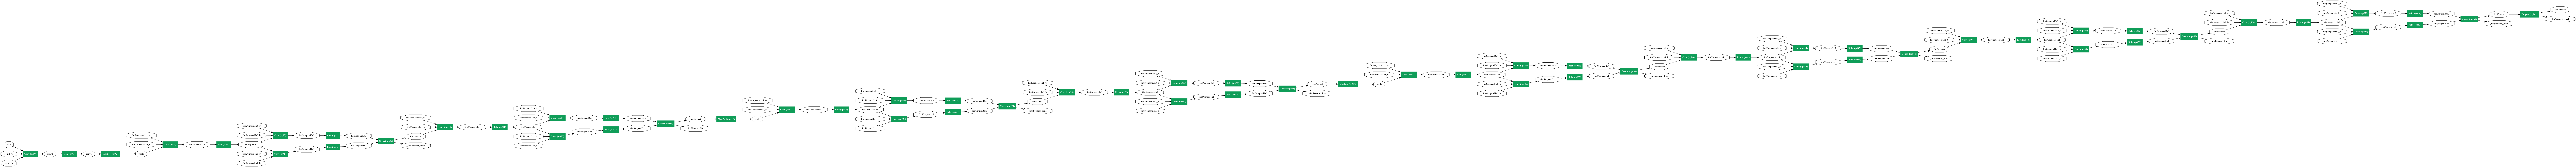

In [23]:
# 在把上面训练数据读出来之后这里可能内存不足
from IPython import display
graph2 = net_drawer.GetPydotGraph(second.Proto().op, "mnist", rankdir="LR")
display.Image(graph2.create_png(), width=1800)

In [24]:
new_model = model_helper.ModelHelper(name='new model', init_params = True)
# add Input
batch_size = 32
input_file = '/home/bingnan/Desktop/data/train_lmdb'
data, label = new_model.TensorProtosDBInput(
    [], ['data', 'label'], batch_size=batch_size,
    db=input_file, db_type='lmdb')
# add other part
new_model.net.AppendNet(second)
new_model.param_init_net.AppendNet(second_init)
# we already know the output of conv10 is (1, 1000, 14, 14)
# and the output for fire9/concat is (1, 512, 14, 14)

fire9concat_stop = new_model.StopGradient('fire9/concat', 'fire9concat_stop')
conv10 = brew.conv(new_model, fire9concat_stop, 'conv10', 512, 12, 1)
conv10 = brew.relu(new_model, conv10, 'conv10')
pool10 = brew.average_pool(new_model, conv10, 'pool10', kernel=14, stride=14)


pred = brew.fc(new_model, 'pool10', 'pred', 12 * 1 * 1, 12)
softmax = brew.softmax(new_model, 'pred', 'softmax')

accuracy = brew.accuracy(new_model, [softmax, 'label'], 'accuracy')

xent = new_model.LabelCrossEntropy([softmax, 'label'], 'xent')
loss = new_model.AveragedLoss(xent, 'loss')
new_model.AddGradientOperators([loss])
optimizer.build_sgd(
    new_model,
    base_learning_rate = 0.01,
    policy = 'step',
    stepsize = 1,
    gamma = 0.999)

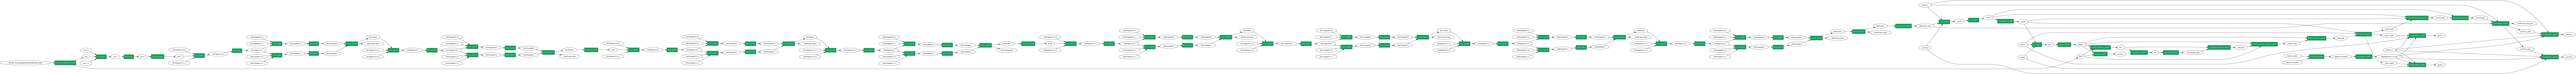

In [25]:
# 在把上面训练数据读出来之后这里可能内存不足
graph2 = net_drawer.GetPydotGraph(new_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph2.create_png(), width=1800)

In [26]:
# test_model
test_model = model_helper.ModelHelper(
    name="test model",init_params=False)
# # add Input
# batch_size = 32
# input_file = '/home/bingnan/Desktop/data/test_lmdb'
# data, label = test_model.TensorProtosDBInput(
#     [], ['data', 'label'], batch_size=batch_size,
#     db=input_file, db_type='lmdb')
# add other part
test_model.net.AppendNet(second)
test_model.param_init_net.AppendNet(second_init)
# we already know the output of conv10 is (1, 1000, 14, 14)
# and the output for fire9/concat is (1, 512, 14, 14)

fire9concat_stop = test_model.StopGradient('fire9/concat', 'fire9concat_stop')
conv10 = brew.conv(test_model, fire9concat_stop, 'conv10', 512, 12, 1)
conv10 = brew.relu(test_model, conv10, 'conv10')
pool10 = brew.average_pool(test_model, conv10, 'pool10', kernel=14, stride=14)


pred = brew.fc(test_model, 'pool10', 'pred', 12 * 1 * 1, 12)
softmax = brew.softmax(test_model, 'pred', 'softmax')

In [27]:
# train model
workspace.ResetWorkspace()
workspace.RunNetOnce(new_model.param_init_net)
workspace.CreateNet(new_model.net, overwrite = True)

total_iters = 100
accuracy = np.zeros(total_iters)

for i in range(total_iters):
    workspace.RunNet(new_model.net)
    accuracy[i] = workspace.FetchBlob('accuracy')
    if (i+1) % 25 == 0:
        print("Iter {}, Acc {}".format(i, accuracy[i]))

Iter 24, Acc 0.34375
Iter 49, Acc 0.40625
Iter 74, Acc 0.46875
Iter 99, Acc 0.625


In [28]:
workspace.FetchBlob('data')

array([[[[-1.08199738e+02, -1.10597717e+02, -1.11648247e+02, ...,
          -7.01233215e+01, -7.08355789e+01, -7.27242661e+01],
         [-1.03680031e+02, -1.06028633e+02, -1.07778633e+02, ...,
          -6.89406586e+01, -6.93620911e+01, -6.85296783e+01],
         [-9.75591660e+01, -1.03016525e+02, -1.05204590e+02, ...,
          -6.93996506e+01, -6.83067398e+01, -7.04127350e+01],
         ...,
         [-9.41538773e+01, -9.53820953e+01, -9.60095139e+01, ...,
          -7.10185928e+01, -7.08508682e+01, -7.45302734e+01],
         [-9.60012283e+01, -9.71349792e+01, -9.92247391e+01, ...,
          -6.92773209e+01, -7.03492355e+01, -7.57856445e+01],
         [-1.00774643e+02, -1.00613022e+02, -9.92730789e+01, ...,
          -7.21266556e+01, -6.65620575e+01, -7.60243149e+01]],

        [[-9.58245773e+01, -1.00105614e+02, -1.03546600e+02, ...,
          -5.46247711e+01, -5.46247711e+01, -5.70490646e+01],
         [-8.78075027e+01, -9.19984436e+01, -9.68841705e+01, ...,
          -5.22489586e

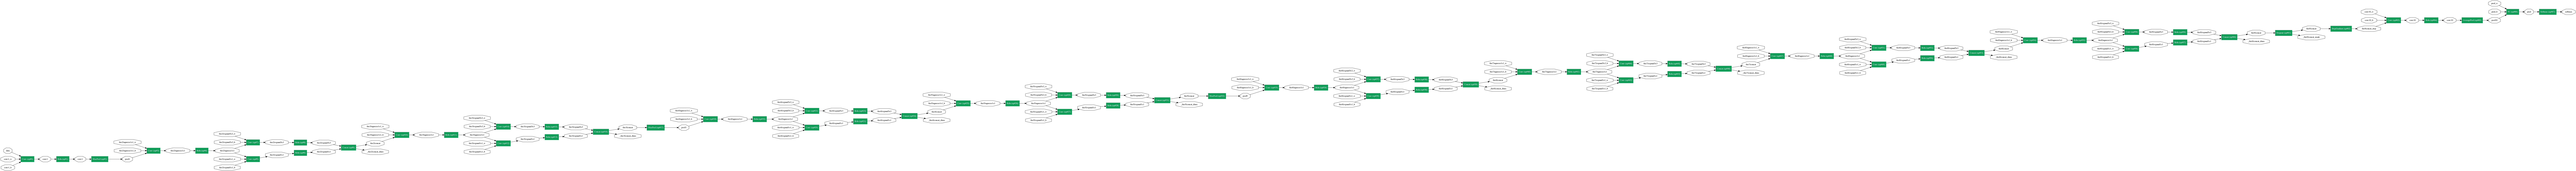

In [30]:
graph = net_drawer.GetPydotGraph(test_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=1800)

In [31]:
workspace.FetchBlob('conv10_b')

array([-0.00408269,  0.00051906, -0.00102805, -0.0036947 , -0.00406901,
       -0.00430174,  0.00066807, -0.00127194, -0.00135138, -0.00160812,
       -0.00156713,  0.00098699], dtype=float32)

## use test imgs

In [90]:
def read_db(input_file):
    print('>>>Reading this database ...')
    model = model_helper.ModelHelper(name='lmdbtest')
    batch_size = 64
    data, label = model.TensorProtosDBInput(
        [], ['data', 'label'], batch_size=batch_size,
        db=input_file, db_type='lmdb')
    
    workspace.RunNetOnce(model.param_init_net)
    workspace.CreateNet(model.net)
    
    for i in range(1):
        if i % 1000 == 0: 
            print(i)
        workspace.RunNet(model.net.Proto().name)

        img_datas = workspace.FetchBlob('data')
        labels = workspace.FetchBlob('label')

    return [img_datas, labels]

test_data = '/home/bingnan/Desktop/data/test_lmdb'
(data_yielder, label) = read_db(test_data)

>>>Reading this database ...
0


In [89]:
label

array([ 0,  6,  7,  1,  8, 11, 10, 11,  6, 11,  8,  5,  7, 11,  3,  9,  6,
        5,  4,  3,  8,  6,  2,  2, 10,  9,  3,  0, 10,  6, 11,  6],
      dtype=int32)

In [92]:
label[32:]

array([ 0,  6,  7,  1,  8, 11, 10, 11,  6, 11,  8,  5,  7, 11,  3,  9,  6,
        5,  4,  3,  8,  6,  2,  2, 10,  9,  3,  0, 10,  6, 11,  6],
      dtype=int32)

In [66]:
# 其实这里我不需要再feedblob了，因为我runnet一遍之后已经有了这个blob
import operator

workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite = True)
workspace.FeedBlob('data', data)
workspace.FeedBlob('label', label)
workspace.RunNet(test_model.net)

ytrue = workspace.FetchBlob('label')
ypred = np.array([max(enumerate(workspace.FetchBlob('softmax')[i]), key=operator.itemgetter(1))[0] for i in range(32)])
(ytrue==ypred).mean()

0.5